## Breast Cancer Prediction

In [1]:
# Import necessary packages
import os , glob 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import skimage
from skimage.io import imread , imread_collection 

from sklearn.metrics import accuracy_score , classification_report
from sklearn.preprocessing import LabelEncoder,StandardScaler

import keras
from keras.applications import mobilenet
from keras.layers import Dense ,Dropout
from keras.models import Sequential

Using TensorFlow backend.


In [5]:
images_path ='../Data/Images/*/'
patient_list = list(glob.glob(images_path))
print('Number of the patient :{}'.format(str(len(patient_list))))

sum = 0
for i in range(0 , len(patient_list)):
    sum+=len(glob.glob(patient_list[i]+'/*/*'))
print('Number of the images :{}'.format(sum))

Number of the patient :280
Number of the images :278082


In [6]:
test=[glob.glob(patient_list[i]+'/*/*') for i in range(0,len(patient_list))]

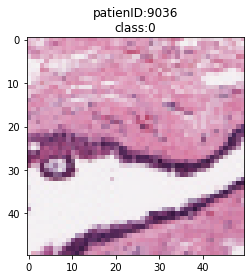

In [7]:
img_sample = imread(test[0][0])
plt.title('patienID:'
          +str(test[0][0].split('/')[3])+'\n'
         'class:'+str(test[0][0].split('/')[4]))
plt.imshow(img_sample)

In [8]:
patient_ID = [test[i][x].split('/')[3]for i in range(0,len(test))for x in range(0,len(test[i]))]
class_test = [test[i][x].split('/')[4]for i in range(0,len(test))for x in range(0 ,len(test[i]))]
patient_pathes = [test[i][x]for i in range(0,len(test))for x in range(0,len(test[i]))]

In [9]:
d = {'patient_ID':patient_ID,'pathes':patient_pathes,'diagnosis':class_test}
BC_df = pd.DataFrame(data=d)

In [10]:
print('The shape of our datset:'+" "+str(BC_df.shape))
BC_df.head()

The shape of our datset: (278082, 3)


,patient_ID,pathes,diagnosis
0,9036,../Data/Images/9036/0/9036_idx5_x1051_y2401_cl...,0
1,9036,../Data/Images/9036/0/9036_idx5_x2951_y951_cla...,0
2,9036,../Data/Images/9036/0/9036_idx5_x3001_y1451_cl...,0
3,9036,../Data/Images/9036/0/9036_idx5_x3051_y801_cla...,0
4,9036,../Data/Images/9036/0/9036_idx5_x951_y1901_cla...,0


In [11]:
BC_df = BC_df[(BC_df['diagnosis']=='0')|(BC_df['diagnosis']=='1')]  

In [12]:
print('The shape of new edited BC_df csv :'+' '+str(BC_df.shape))


The shape of new edited BC_df csv : (277524, 3)


In [13]:
BC_df['diagnosis'].value_counts()

0    198738
1     78786
Name: diagnosis, dtype: int64

In [14]:
BC_copy_1 = BC_df.iloc[:20000,:]
from PIL.Image import open
BC_copy_1['pixels'] =  BC_copy_1['pathes'].map(lambda x:np.asarray(open(x).resize((224,224))).astype(np.float32))

/Users/chandramouliyalamanchili/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
BC_copy_1['pixels'] = BC_copy_1['pixels'].tolist()
BC_copy_1.head()

/Users/chandramouliyalamanchili/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,patient_ID,pathes,diagnosis,pixels
0,9036,../Data/Images/9036/0/9036_idx5_x1051_y2401_cl...,0,"[[[229.0, 193.0, 212.0], [229.0, 193.0, 212.0]..."
1,9036,../Data/Images/9036/0/9036_idx5_x2951_y951_cla...,0,"[[[209.0, 167.0, 198.0], [209.0, 167.0, 198.0]..."
2,9036,../Data/Images/9036/0/9036_idx5_x3001_y1451_cl...,0,"[[[236.0, 222.0, 232.0], [236.0, 222.0, 232.0]..."
3,9036,../Data/Images/9036/0/9036_idx5_x3051_y801_cla...,0,"[[[143.0, 110.0, 153.0], [143.0, 110.0, 153.0]..."
4,9036,../Data/Images/9036/0/9036_idx5_x951_y1901_cla...,0,"[[[226.0, 169.0, 195.0], [226.0, 169.0, 195.0]..."


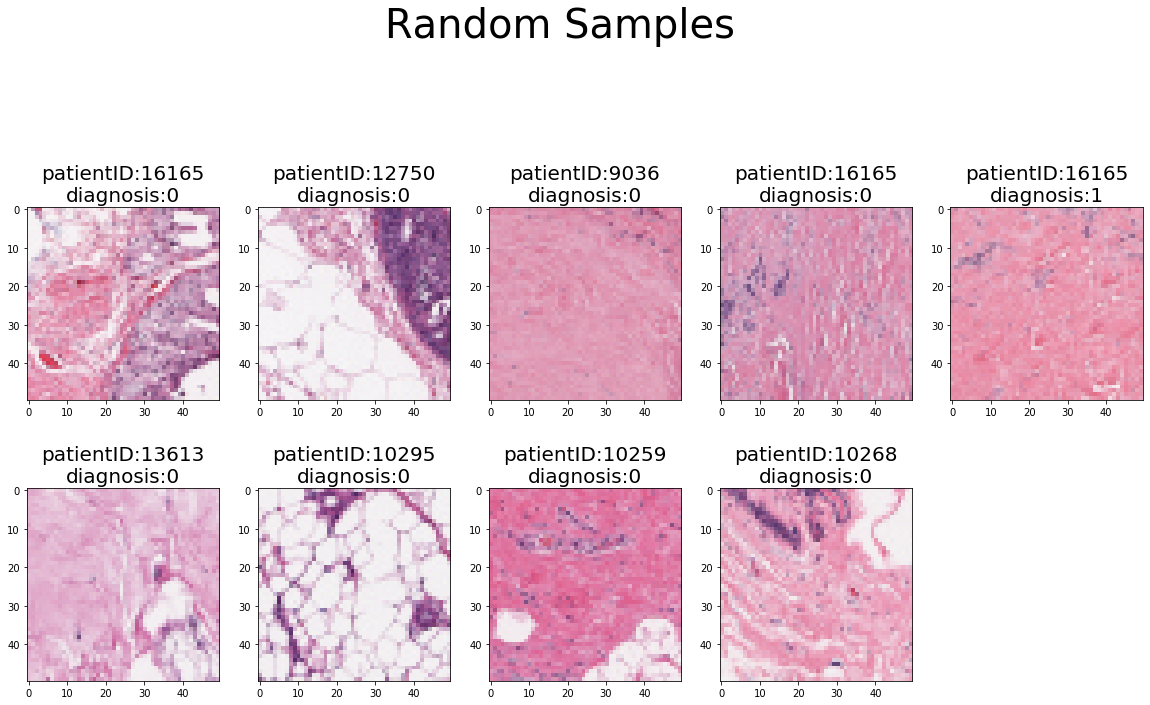

In [17]:
from random import choice
fig,axes = plt.subplots(figsize=(20,25))
  
ran_sample = [choice(BC_copy_1['pathes'])for x in range(0,10) ]
for i in range(0,len(ran_sample)):
    img = imread(ran_sample[i])
    plt.imshow(img)
    axes =plt.subplot(5,5,i+1)
    axes.set_title('patientID:'+str(ran_sample[i].split('/')[3])+'\n'
                   +'diagnosis:'+str(ran_sample[i].split('/')[4]),fontsize=20)

# There was a blank plot 
# so remove it via 'delaxes'
fig.delaxes(axes)
fig.suptitle('Random Samples ',fontsize=40)
plt.show() 

0    16051
1     3949
Name: diagnosis, dtype: int64


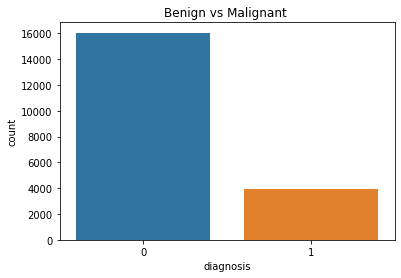

The difference between benign and malignant : 12102


In [18]:
BC_count = BC_copy_1['diagnosis'].value_counts()
print(BC_count)
sns.countplot(BC_copy_1['diagnosis'])
plt.title('Benign vs Malignant ')
plt.show()
print('The difference between benign and malignant :'+" "
      +str(BC_count[0]-BC_count[1]))